In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
elif PROJECT_ROOT.name.startswith("0"):
    PROJECT_ROOT = PROJECT_ROOT.parent.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

%load_ext autoreload
%autoreload 2

In [2]:
# !pip install shap
# !pip install hyperopt
# !pip install loguru
# !pip install lightgbm

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Data Management
import json
import numpy as np
import pandas as pd

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier

# Opti
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from match_forecast.utils import *

2025-04-18 15:51:04.648 | INFO     | match_forecast.config:<module>:11 - PROJ_ROOT path is: /home/onyxia/work/QRT-Challenge-2024


In [4]:
PROJ_ROOT = Path("QRT-Challenge-2024").resolve().parents[1]
DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

In [5]:
try:
    train_data = pd.read_csv(PROCESSED_DATA_DIR / "train_data.csv", index_col=0)
    train_scores = pd.read_csv(RAW_DATA_DIR / "Y_train.csv", index_col=0)
    print("Files loaded")
    
except FileNotFoundError as e:
    print(e)

Files loaded


In [6]:
train_scores = train_scores.loc[train_data.index]
train_scores_1c = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']].idxmax(axis=1)
label_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
train_scores_1c = train_scores_1c.replace(label_mapping)

train_scores_1c.head(5)

ID
0    2
1    1
2    2
3    0
4    1
dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_scores_1c, train_size=0.8, random_state=42)

In [8]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 2000, 50),  
    'max_depth': hp.quniform('max_depth', 2, 30, 1),  
    'max_features': hp.uniform('max_features', 0.2, 0.8),
    'min_samples_split': hp.quniform('min_samples_split', 2, 50, 2),  
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),  
    'criterion': hp.choice('criterion', ['gini', 'entropy']),  
    'class_weight': hp.choice('class_weight', [None, 'balanced', 'balanced_subsample']),  
    'max_leaf_nodes': hp.quniform('max_leaf_nodes', 10, 1000, 10),  
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.0, 0.5),  
}

In [9]:
n_splits = 3

def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    params['max_leaf_nodes'] = int(params['max_leaf_nodes']) if params['max_leaf_nodes'] is not None else None

    max_features = params['max_features']
    if isinstance(max_features, float):  
        params['max_features'] = max_features
    elif isinstance(max_features, str):  
        params['max_features'] = max_features
    else:  
        params['max_features'] = None
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, valid_index in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        model = ExtraTreesClassifier(**params, random_state=42, n_jobs=-1)
        model.fit(X_train_fold, y_train_fold)

        y_pred = model.predict(X_valid_fold)
        accuracy = accuracy_score(y_valid_fold, y_pred)
        accuracies.append(accuracy)

    mean_loss = 1 - np.mean(accuracies)
    return {'loss': mean_loss, 'status': STATUS_OK}


In [10]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=150, 
            trials=trials)

print("Best hyperparameters:", best)

100%|██████████| 150/150 [58:02<00:00, 23.21s/trial, best loss: 0.5044700889328309] 
Best hyperparameters: {'class_weight': np.int64(0), 'criterion': np.int64(1), 'max_depth': np.float64(21.0), 'max_features': np.float64(0.5519654919904953), 'max_leaf_nodes': np.float64(540.0), 'min_impurity_decrease': np.float64(0.0003623844908814313), 'min_samples_leaf': np.float64(2.0), 'min_samples_split': np.float64(14.0), 'n_estimators': np.float64(100.0)}


In [11]:
# Convert NumPy types to native Python types for JSON serialization
def convert_numpy(obj):
    if isinstance(obj, np.integer):
        return int(obj)  
    elif isinstance(obj, np.floating):
        return float(obj)  
    elif isinstance(obj, list):  
        return [convert_numpy(i) for i in obj]  
    elif isinstance(obj, dict):  
        return {key: convert_numpy(value) for key, value in obj.items()}  
    else:
        return obj

results_with_params = [
    {
        **convert_numpy(trial['result']),
        'params': {key: convert_numpy(value[0]) if value else None for key, value in trial['misc']['vals'].items()}  # Convert hyperparameters
    }
    for trial in trials.trials[:-1]
]

with open('xt_model.json', 'w') as f:
    json.dump(results_with_params, f, indent=4)

print("Optimization results saved to 'xt_model.json'")


Optimization results saved to 'xt_model.json'


In [12]:
with open("xt_model.json", "r") as f:
    results_with_params = json.load(f)

print("\nBest trial")
best_trial = min(results_with_params, key=lambda x: x["loss"])
print("Best hyperparameters:", best_trial["params"])
print("Best loss:", best_trial["loss"])


Best trial
Best hyperparameters: {'class_weight': 0, 'criterion': 1, 'max_depth': 21.0, 'max_features': 0.5519654919904953, 'max_leaf_nodes': 540.0, 'min_impurity_decrease': 0.0003623844908814313, 'min_samples_leaf': 2.0, 'min_samples_split': 14.0, 'n_estimators': 100.0}
Best loss: 0.5044700889328309


In [13]:
# Convert hyperparameters to correct types
best_trial['params']['n_estimators'] = int(best_trial['params']['n_estimators'])
best_trial['params']['max_depth'] = int(best_trial['params']['max_depth'])
best_trial['params']['min_samples_split'] = int(best_trial['params']['min_samples_split'])
best_trial['params']['min_samples_leaf'] = int(best_trial['params']['min_samples_leaf'])
best_trial['params']['max_leaf_nodes'] = int(best_trial['params']['max_leaf_nodes']) if best_trial['params']['max_leaf_nodes'] is not None else None

class_weight_options = [None, 'balanced', 'balanced_subsample']
if isinstance(best_trial['params']['class_weight'], (int, np.integer)):  # Ensure it's an index
    best_trial['params']['class_weight'] = class_weight_options[int(best_trial['params']['class_weight'])]


criterion_options = ['gini', 'entropy']
if isinstance(best_trial['params']['criterion'], (int, np.integer)):
    best_trial['params']['criterion'] = criterion_options[int(best_trial['params']['criterion'])]

In [14]:
final_model = ExtraTreesClassifier(
    **best_trial['params'],
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

ExtraTreesClassifier(criterion='entropy', max_depth=21,
                     max_features=0.5519654919904953, max_leaf_nodes=540,
                     min_impurity_decrease=0.0003623844908814313,
                     min_samples_leaf=2, min_samples_split=14, n_jobs=-1,
                     random_state=42)

In [15]:
y_pred_final = final_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Accuracy (test) : {final_accuracy * 100:.2f}%")

Accuracy (test) : 49.53%


In [16]:
importance_dict = dict(zip(
    X_train.columns,
    final_model.feature_importances_
))

sorted_features = sorted(
    importance_dict.items(),
    key=lambda x: x[1],
    reverse=True
)
top_features = [feature for feature, score in sorted_features[:10]]

X_reduced = train_data[top_features]

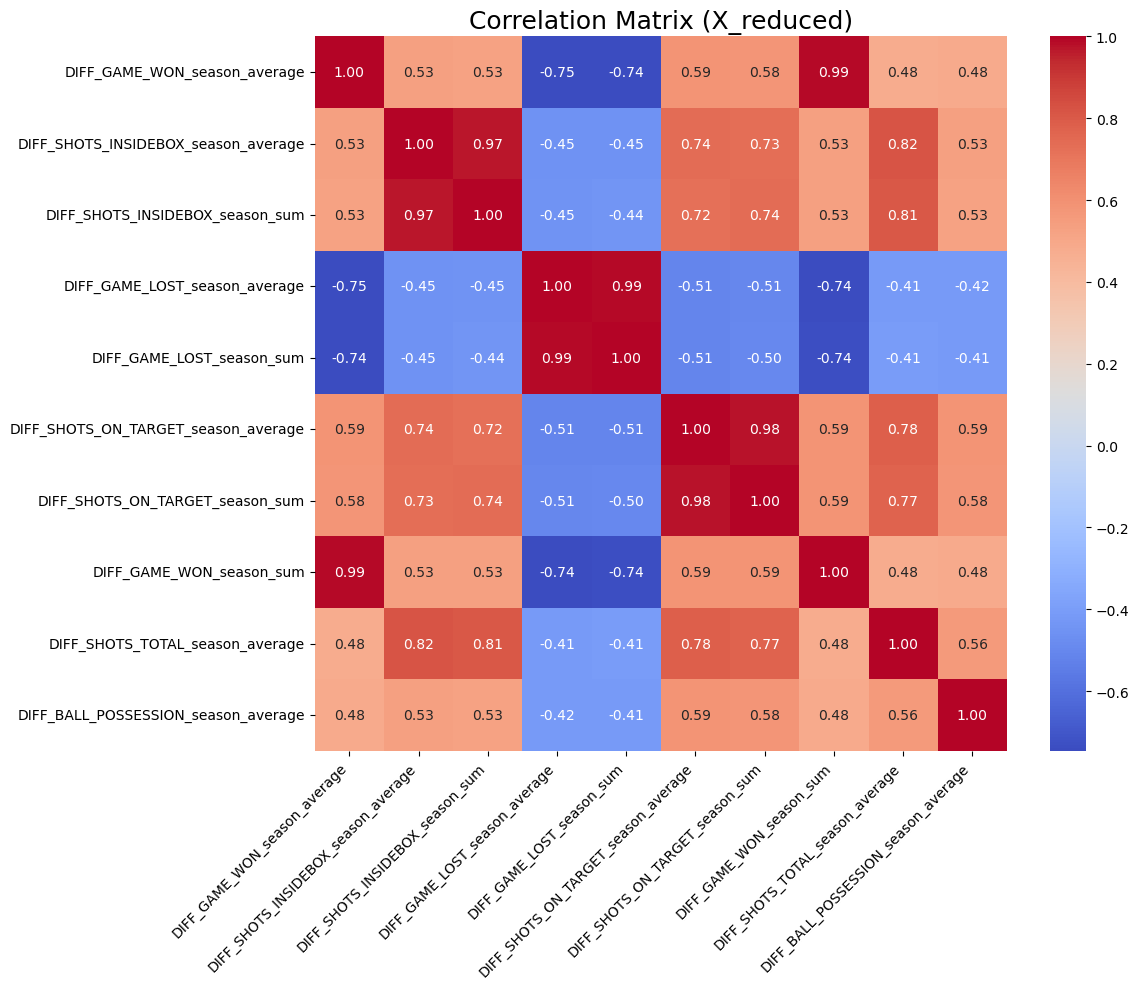

In [17]:
plot_correlation_matrix(X_reduced, title="Correlation Matrix (X_reduced)")

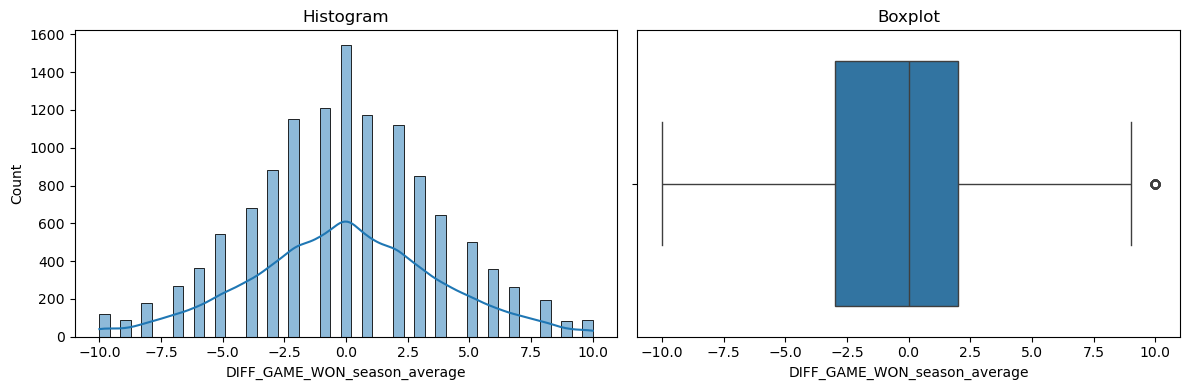

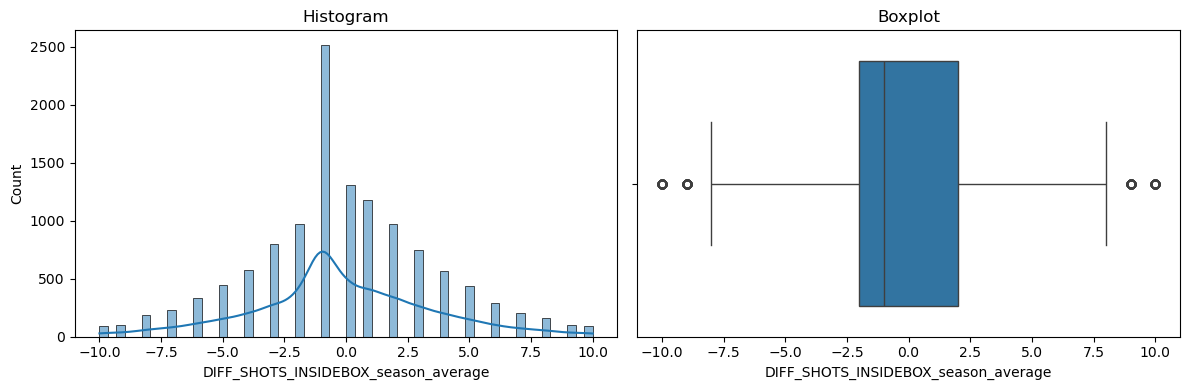

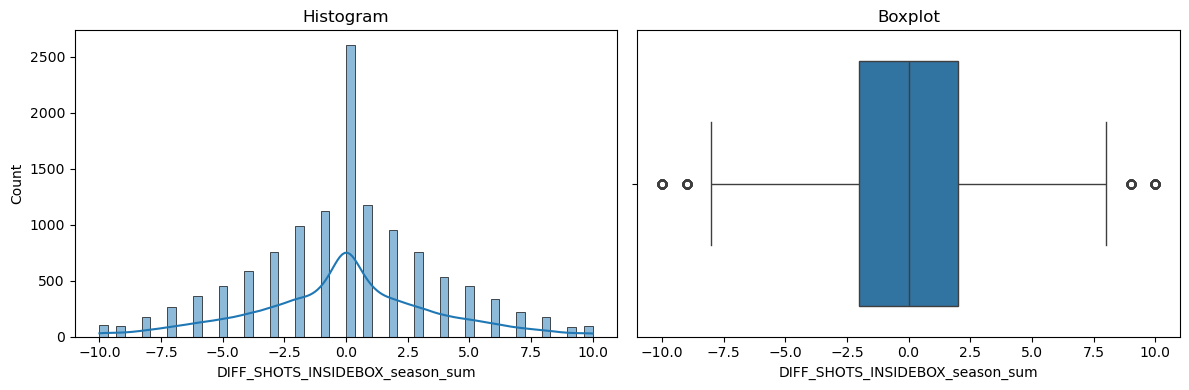

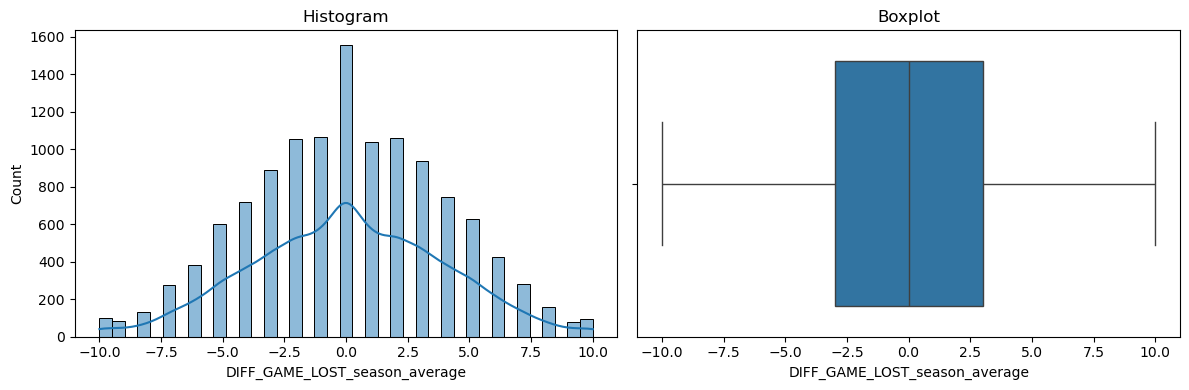

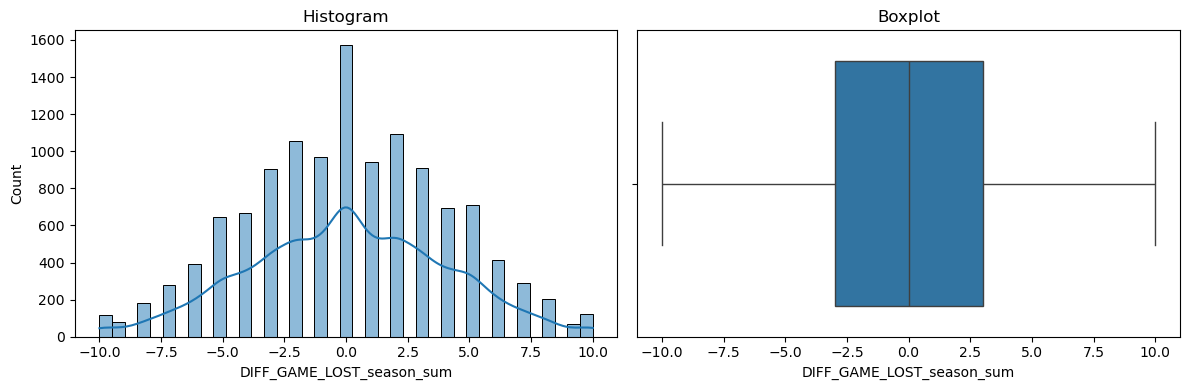

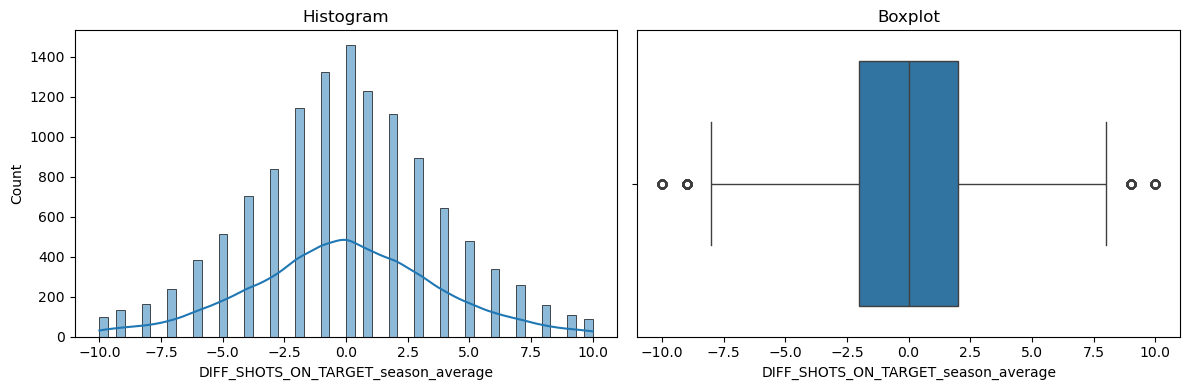

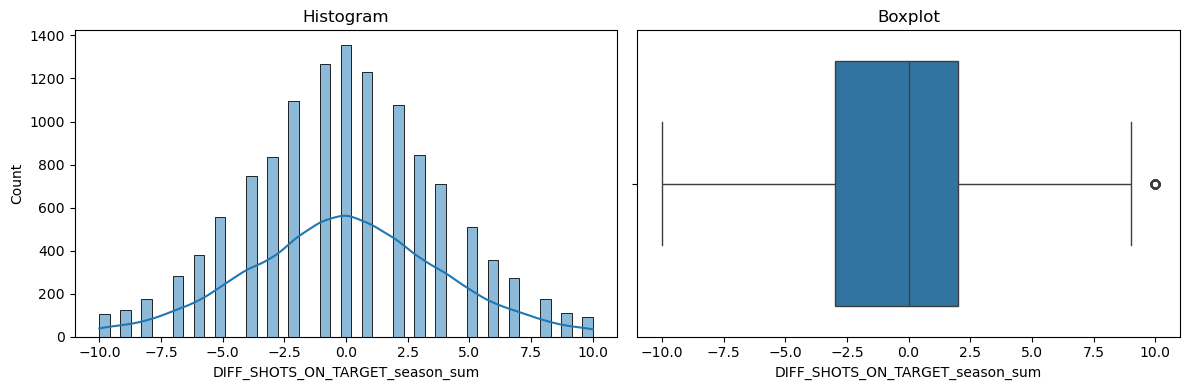

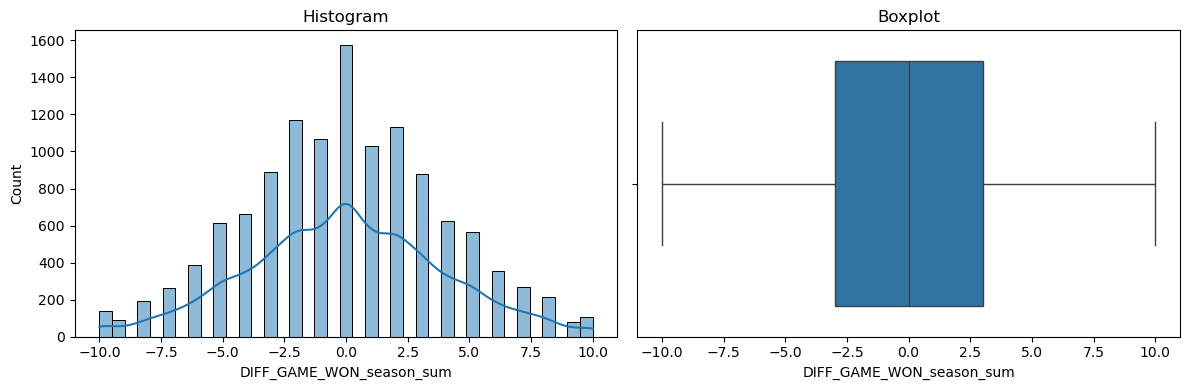

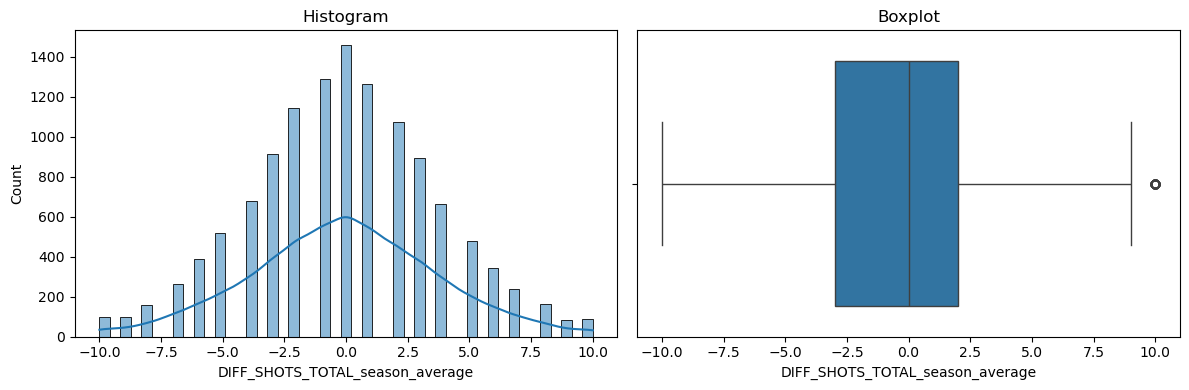

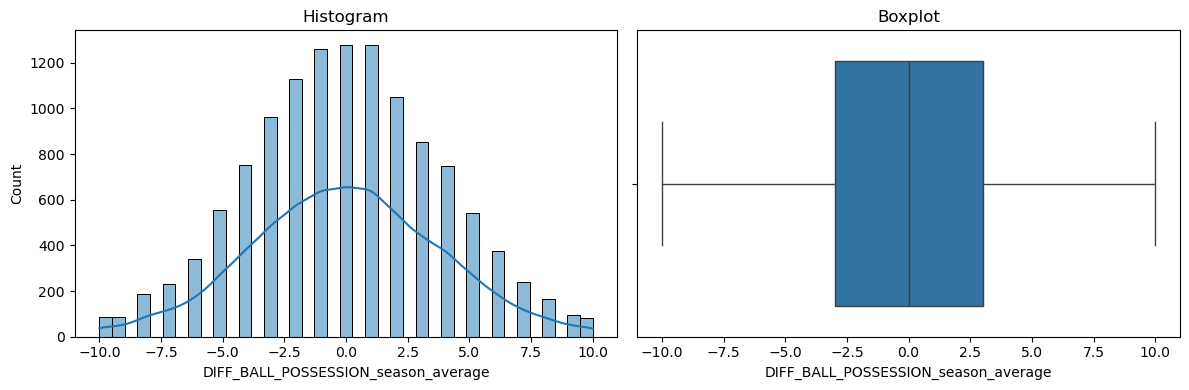

In [18]:
num_cols = X_reduced.select_dtypes(include=[np.number]).columns
cat_cols = X_reduced.select_dtypes(include=["object", "category"]).columns
plot_univariate_analysis(X_reduced, numeric_cols=num_cols, categorical_cols=cat_cols)